In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#database connection settings
import psycopg2

db_name = "traviato_development"
db_host = "localhost"
db_port = "5432"
db_user = "lievgarcia"
db_pwd = "traviato81"

conn = psycopg2.connect(database=db_name, user=db_user, password=db_pwd, host=db_host, port=db_port)

In [3]:
######################## libraries ########################

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np

import sys
sys.path.append('../../')

from utils.utility_functions import label_top
from utils.utility_functions import get_last_name
from utils.utility_functions import make_dash_zero
# from utils.utility_functions import shorten_opera_name

##################### CHARTING OPTIONS #####################

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Palatino']})

rc('text', usetex=True)
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45', '#8a170f']


##################### SOURCES OPTIONS #####################

archival_sources = ['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper', 
                    'Chicago Lyric Opera','San Francisco Opera','Czech National Theatre','Glyndebourne','Salzburg Festival',
                    'Sweden Opera House','National Opera de Paris','Opera Comique']
commercial_sources_world = ['bachtrack.com','operabase.com','operacritic.com']
commercial_sources_uk = ['Concert-Diary','U.K. Theatre Web']
government_sources = ['National Central Opera Service Reports', 'Opera America']

##############################################################################

In [254]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 'date_start', 'date_end', 'premiere_date', 'performance_count']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "ORDER BY s.id, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)

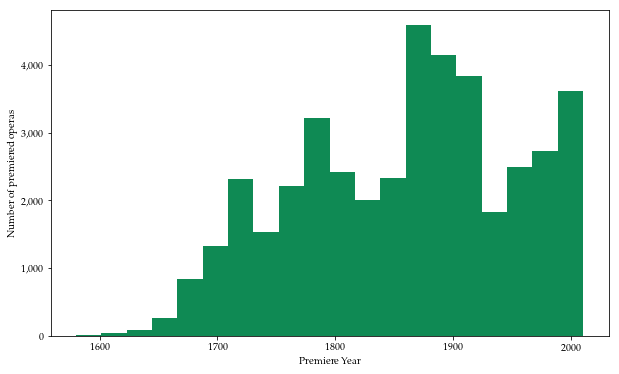

In [232]:
w_df = pd.read_csv('../../../data/processed/works/stanford.csv', index_col=0)
w_df = w_df[w_df['year']!=2099]
w_df = w_df[w_df['genre']!='Operetta']
w_df['decade'] = w_df.apply(lambda row: 10*int(row['year']/10), axis=1)
w_df.head()

w_df['decade'].plot.hist(figsize=(10, 6), color=colors[5], bins=20)
plt.ylabel('Number of premiered operas')
plt.xlabel('Premiere Year')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

(1, 40)

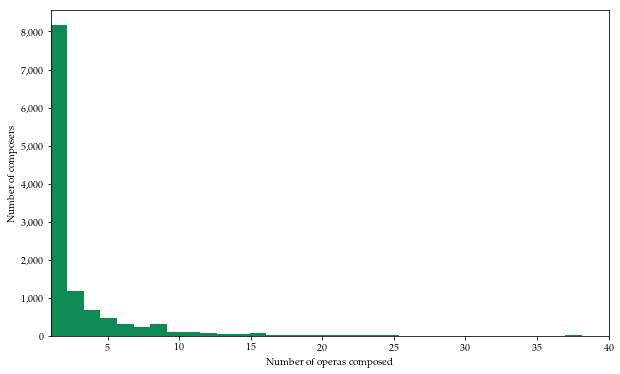

In [233]:
w_df = pd.read_csv('../../../data/processed/works/stanford.csv', index_col=0)
w_df = w_df[w_df['year']!=2099]
w_df = w_df[w_df['genre']!='Operetta']
w_df = w_df[w_df['composer']!='Antonio Draghi']

w_df['decade'] = w_df.apply(lambda row: 10*int(row['year']/10), axis=1)
w_df = w_df.groupby('composer').agg({'name': 'count'})
w_df = w_df.reset_index(level=['composer'])

# w_df.head()

w_df['name'].hist(figsize=(10, 6), color=colors[5], bins=100, grid=False, xlabelsize=10)
plt.plot()
plt.ylabel('Number of composers')
plt.xlabel('Number of operas composed')
ax = plt.gca()
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

left_edge = 1
right_edge = 40
ax.set_xlim(left_edge, right_edge)

In [251]:
#################### top composers share of repertoire ####################

sources = archival_sources
# print(sources)
num_sources = len(sources)

o_df = mdf.copy()
# o_df = o_df[o_df['source_name']=='Metropolitan Opera']
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['year'] < 2019]

o_df['top_composer'] = 'No'
o_df['top_work'] = 'No'

for source in sources:
#     print(source)
    c_df = o_df[o_df['source_name']==source]    
    c_df = c_df.groupby(['composer', 'decade']).agg({'performance_count': np.sum })
    c_df = c_df.reset_index(level=['composer', 'decade'])
    years = c_df['decade'].unique()
    years.sort()

    for year in years:
        y_df = c_df[c_df['decade']<=year]
        y_df = y_df.groupby(['composer'])
        y_df = y_df.agg({'performance_count': np.sum })    
        y_df = y_df.sort_values(by=['performance_count'], ascending=False)    
        top = y_df.head(5)
        for composer in list(top.index):
            o_df.loc[(o_df['source_name']==source)&(o_df['composer']==composer)&(o_df['decade']==year), 'top_composer']='Yes'

o_df = o_df[o_df['decade'] >= 1770]
c_df = o_df.groupby(['source_name', 'decade', 'top_composer']).agg({'performance_count': np.sum })
c_df = c_df.groupby(level = ['source_name', 'decade']).transform(lambda x: x/x.sum())
c_df = c_df.reset_index(level=['decade', 'top_composer', 'source_name'])
c_df = c_df[c_df['top_composer']=='Yes']

c_df['performance_count']=c_df['performance_count']*100
d_df = c_df.pivot(index='decade', columns='source_name', values=['performance_count'])
# d_df = c_df.pivot(index='source_name', columns='decade', values=['performance_count'])
d_df = d_df.fillna(value=0)
d_df = d_df.round(2)
# pd.options.display.float_format = '{:.2f}%'.format

decades = d_df.columns.get_level_values(1).get_values().tolist()
decades = [str(d) for d in decades]

print('r'*len(decades))
print('\\textbf{Composer} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in d_df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values ]
    print(str(row.name) + ' & ' + ' & '.join(values) + " \\\\")

###############################################################

rrrrrrrrrrrrr
\textbf{Composer} & \textbf{Chicago Lyric Opera & \textbf{Czech National Theatre & \textbf{Glyndebourne & \textbf{Metropolitan Opera & \textbf{National Opera de Paris & \textbf{Opera Comique & \textbf{Opera Scotland & \textbf{Royal Opera House & \textbf{Salzburg Festival & \textbf{San Francisco Opera & \textbf{Sweden Opera House & \textbf{Teatro alla Scala & \textbf{Wiener Staatsoper \\ \midrule 
1770 & - & - & - & - & - & 89 & - & - & - & - & 69 & - & - \\
1780 & - & - & - & - & - & - & - & - & - & - & 53 & - & - \\
1790 & - & - & - & - & - & 50 & - & - & - & - & 64 & - & - \\
1800 & - & - & - & - & - & 11 & - & - & - & - & 48 & - & - \\
1810 & - & - & - & - & - & 49 & - & - & - & - & 38 & - & - \\
1820 & - & - & - & - & - & 43 & - & - & - & - & 28 & - & - \\
1830 & - & - & - & - & - & 44 & - & - & - & - & 21 & - & - \\
1840 & - & - & - & - & - & 14 & - & - & - & - & 15 & - & - \\
1850 & - & - & - & - & - & 24 & - & - & - & - & 23 & - & - \\
1860 & - & - & - & - & - & 20

In [ ]:
#################### top composers share of repertoire ####################

sources = archival_sources
# print(sources)
num_sources = len(sources)

o_df = mdf.copy()
o_df = o_df[o_df['source_name']=='Metropolitan Opera']
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['year'] < 2019]


for source in sources:
#     print(source)
    c_df = o_df[o_df['source_name']==source]    
    c_df = c_df.groupby(['composer', 'decade']).agg({'performance_count': np.sum })
    c_df = c_df.reset_index(level=['composer', 'decade'])
    years = c_df['decade'].unique()
    years.sort()

    for year in years:
        y_df = c_df[c_df['decade']<=year]
        y_df = y_df.groupby(['composer'])
        y_df = y_df.agg({'performance_count': np.sum })    
        y_df = y_df.sort_values(by=['performance_count'], ascending=False)    
        top = y_df.head(5)
        for composer in list(top.index):
            o_df.loc[(o_df['source_name']==source)&(o_df['composer']==composer)&(o_df['decade']==year), 'top_composer']='Yes'

o_df = o_df[o_df['decade'] >= 1770]
c_df = o_df.groupby(['source_name', 'decade', 'top_composer']).agg({'performance_count': np.sum })
c_df = c_df.groupby(level = ['source_name', 'decade']).transform(lambda x: x/x.sum())
c_df = c_df.reset_index(level=['decade', 'top_composer', 'source_name'])
c_df = c_df[c_df['top_composer']=='Yes']

c_df['performance_count']=c_df['performance_count']*100
d_df = c_df.pivot(index='decade', columns='source_name', values=['performance_count'])
# d_df = c_df.pivot(index='source_name', columns='decade', values=['performance_count'])
d_df = d_df.fillna(value=0)
d_df = d_df.round(2)
# pd.options.display.float_format = '{:.2f}%'.format

decades = d_df.columns.get_level_values(1).get_values().tolist()
decades = [str(d) for d in decades]


###############################################################

In [238]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 'date_start', 'date_end', 'premiere_date', 'performance_count', 'theatre_category']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count, " + \
        "       CASE WHEN l.source_id = 1 then 'Professional' when opera_america_name IS NULL THEN 'Amateur' ELSE 'Professional' END as theatre_category " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN theatre_mapping tm ON l.theatre = tm.name " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "WHERE source_id IN (1, 6) AND w.uri != 'W1' " + \
        "ORDER BY s.id, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)

mdf.loc[mdf['theatre']=='New York City Opera', 'theatre_category'] = 'Professional'

In [239]:
#################### top composers share of repertoire ####################

sources = government_sources
# print(sources)
num_sources = len(sources)

o_df = mdf.copy()
# o_df = o_df[o_df['source_name']=='Metropolitan Opera']
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['year'] < 2019]

o_df['top_composer'] = 'No'
o_df['top_work'] = 'No'

sources = o_df['theatre_category'].unique()

for source in sources:
#     print(source)
    c_df = o_df[o_df['theatre_category']==source]    
    c_df = c_df.groupby(['composer', 'decade']).agg({'performance_count': np.sum })
    c_df = c_df.reset_index(level=['composer', 'decade'])
    years = c_df['decade'].unique()
    years.sort()

    for year in years:
        y_df = c_df[c_df['decade']<=year]
        y_df = y_df.groupby(['composer'])
        y_df = y_df.agg({'performance_count': np.sum })    
        y_df = y_df.sort_values(by=['performance_count'], ascending=False)    
        top = y_df.head(5)
        for composer in list(top.index):
            o_df.loc[(o_df['theatre_category']==source)&(o_df['composer']==composer)&(o_df['decade']==year), 'top_composer']='Yes'

o_df = o_df[o_df['decade'] >= 1770]
c_df = o_df.groupby(['theatre_category', 'decade', 'top_composer']).agg({'performance_count': np.sum })
c_df = c_df.groupby(level = ['theatre_category', 'decade']).transform(lambda x: x/x.sum())
c_df = c_df.reset_index(level=['decade', 'top_composer', 'theatre_category'])
c_df = c_df[c_df['top_composer']=='Yes']

c_df['performance_count']=c_df['performance_count']*100
d_df = c_df.pivot(index='theatre_category', columns='decade', values=['performance_count'])
# d_df = c_df.pivot(index='source_name', columns='decade', values=['performance_count'])
d_df = d_df.fillna(value=0)
d_df = d_df.round(2)
# pd.options.display.float_format = '{:.2f}%'.format

decades = d_df.columns.get_level_values(1).get_values().tolist()
decades = [str(d) for d in decades[1:]]

print('r'*len(decades))
print('\\textbf{Composer} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in d_df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values[1:] ]
    print(str(row.name) + ' & ' + ' & '.join(values) + " \\\\")

###############################################################

rrrrrr
\textbf{Composer} & \textbf{1960 & \textbf{1970 & \textbf{1980 & \textbf{1990 & \textbf{2000 & \textbf{2010 \\ \midrule 
Amateur & 46 & 44 & 26 & 23 & - & - \\
Professional & 52 & 50 & 40 & 48 & 47 & 47 \\


In [243]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 
         'date_start', 'date_end', 'premiere_date', 'performance_count', 'composer_country']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count, " + \
        "       c.country as composer_country " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "WHERE source_id IN (4, 8, 13) AND w.uri != 'W1' " + \
        "ORDER BY s.id DESC, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)
mdf = mdf[mdf['year'] > 2007]
print(mdf.shape)
mdf = mdf[['composer', 'work', 'country', 'state', 'city', 'date_start', 'date_end', 'premiere_date', 'performance_count', 'year', 'decade', 'work_decade', 'composer_country']]
mdf = mdf.drop_duplicates()
print(mdf.shape)

(250428, 16)
(171608, 13)


In [245]:
#################### top composers share of repertoire ####################

o_df = mdf.copy()
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']

countries_excl = ['Oman','Macedonia','Armenia','South Korea','Egypt','Georgia','Albania','Kyrgyzstan','Mongolia','Singapore',
                  'Bosnia-Herzegovina','Malta','Iceland','Mexico','China','Thailand','Peru','Costa Rica','India','UAE']

o_df = o_df[~o_df['country'].isin(countries_excl)]
countries = o_df['country'].unique().tolist()
countries.sort()
sources = countries


o_df['top_composer'] = 'No'
o_df['top_work'] = 'No'

for source in sources:
#     print(source)
    c_df = o_df[o_df['country']==source]    
    c_df = c_df.groupby(['composer', 'year']).agg({'performance_count': np.sum })
    c_df = c_df.reset_index(level=['composer', 'year'])
    years = c_df['year'].unique()
    years.sort()

    for year in years:
        y_df = c_df[c_df['year']<=year]
        y_df = y_df.groupby(['composer'])
        y_df = y_df.agg({'performance_count': np.sum })    
        y_df = y_df.sort_values(by=['performance_count'], ascending=False)    
        top = y_df.head(5)
        for composer in list(top.index):
            o_df.loc[(o_df['country']==source)&(o_df['composer']==composer)&(o_df['year']==year), 'top_composer']='Yes'

o_df = o_df[o_df['decade'] >= 1770]
c_df = o_df.groupby(['country', 'year', 'top_composer']).agg({'performance_count': np.sum })
c_df = c_df.groupby(level = ['country', 'year']).transform(lambda x: x/x.sum())
c_df = c_df.reset_index(level=['year', 'top_composer', 'country'])
c_df = c_df[c_df['top_composer']=='Yes']

c_df['performance_count']=c_df['performance_count']*100
d_df = c_df.pivot(index='country', columns='year', values=['performance_count'])
# d_df = c_df.pivot(index='source_name', columns='decade', values=['performance_count'])
d_df = d_df.fillna(value=0)
d_df = d_df.round(2)
# pd.options.display.float_format = '{:.2f}%'.format

decades = d_df.columns.get_level_values(1).get_values().tolist()
decades = [str(d) for d in decades]

print('r'*len(decades))
print('\\textbf{Composer} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in d_df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values ]
    print(str(row.name) + ' & ' + ' & '.join(values) + " \\\\")

###############################################################

rrrrrrrrr
\textbf{Composer} & \textbf{2011 & \textbf{2012 & \textbf{2013 & \textbf{2014 & \textbf{2015 & \textbf{2016 & \textbf{2017 & \textbf{2018 & \textbf{2019 \\ \midrule 
Argentina & - & 44 & 61 & 68 & 39 & 50 & 31 & 50 & - \\
Australia & - & 67 & 65 & 80 & 78 & 48 & 30 & 49 & - \\
Austria & 40 & 30 & 38 & 34 & 29 & 35 & 33 & 29 & 22 \\
Azerbaijan & - & - & 83 & 67 & 65 & 40 & 66 & - & - \\
Belarus & - & 71 & 69 & 64 & 66 & 76 & 73 & 77 & - \\
Belgium & 69 & 49 & 62 & 45 & 41 & 52 & 41 & 38 & 29 \\
Bulgaria & 100 & 63 & 73 & 60 & 61 & 56 & 46 & 65 & - \\
Canada & 51 & 56 & 45 & 45 & 39 & 48 & 52 & 34 & 65 \\
Chile & - & 85 & 67 & 37 & 43 & 51 & 71 & 82 & - \\
Croatia & 100 & 55 & 49 & 47 & 55 & 45 & 64 & 60 & - \\
Czech Republic & 74 & 59 & 56 & 55 & 55 & 46 & 49 & 46 & 55 \\
Denmark & 94 & 54 & 73 & 51 & 50 & 75 & 46 & 62 & 25 \\
Estonia & 78 & 58 & 40 & 26 & 54 & 43 & 34 & 31 & 51 \\
Finland & 91 & 66 & 44 & 55 & 38 & 57 & 39 & 63 & 26 \\
France & 42 & 36 & 36 & 34 & 28 & 33 & 3